In [ ]:
# ============================
# Cell 1: Install Dependencies
# ============================

# Core LLM + retrieval dependencies
!pip install -q --no-cache-dir "transformers==4.45.0"
!pip install -q --no-cache-dir byaldi==0.0.4 pdf2image==1.17.0 qwen-vl-utils==0.0.8

# Data processing
!pip install -q --no-cache-dir "pyarrow>=14.0.0,<20.0.0a0"
!pip install -q --no-cache-cache-dir "rich>=12.4.4,<14"
!pip install -q --no-cache-dir faiss-cpu

# PDF parsing + OCR
!pip install -q --no-cache-dir pdfplumber
!pip install -q --no-cache-dir camelot-py[cv]
!pip install -q --no-cache-dir pytesseract pillow
!pip install -q --no-cache-dir opencv-python-headless

# UI
!pip install -q --no-cache-dir streamlit

# OS-level dependencies
!sudo apt-get update -qq
!sudo apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-eng


# ==== Imports ====
import os
import shutil
import re
from typing import List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import cv2

from pdf2image import convert_from_path
import pdfplumber
import camelot
import faiss

from byaldi import RAGMultiModalModel

from transformers import (
    AutoTokenizer,
    AutoModel,
    Qwen2VLForConditionalGeneration,
    Qwen2VLProcessor,
    CLIPProcessor,
    CLIPModel
)

from qwen_vl_utils import process_vision_info
import torch
import streamlit as st

print(" Cell 1 complete: All upgraded dependencies + pdfplumber installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 218.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.13 requires transformers<4.58.0,>=4.53.1, but you have transformers 4.45.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 279.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 218.2 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building depen

In [ ]:
# ============================
# Cell 2: Copy PDFs into ./data
# ============================

dataset_dir = "/content/"  # Adjust if your PDFs are elsewhere
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Logical names → filenames in your dataset folder
pdfs = {
    "QATAR_DOC": "qatar_test_doc.pdf"
    # Add more PDFs here if needed
}

missing_files = []

print(" Checking PDFs...")

for name, filename in pdfs.items():
    src = os.path.join(dataset_dir, filename)
    dst = os.path.join(data_dir, f"{name}.pdf")

    if not os.path.exists(src):
        print(f" MISSING: {src}")
        missing_files.append(src)
        continue

    shutil.copy(src, dst)
    print(f" Copied: {src} → {dst}")

if missing_files:
    print(" WARNING: Some PDF files were missing:")
    for f in missing_files:
        print("  -", f)
else:
    print(" All PDFs copied successfully.")

# List all PDFs actually present in data/
pdf_files = [f for f in os.listdir(data_dir) if f.lower().endswith(".pdf")]
pdf_files.sort()

print(" Files in data/:", pdf_files)
print(" Cell 2 complete: PDFs copied & verified.")

📁 Checking PDFs...
✔ Copied: /content/qatar_test_doc.pdf → data/QATAR_DOC.pdf

📄 All PDFs copied successfully.

📁 Files in data/: ['QATAR_DOC.pdf']
✅ Cell 2 complete: PDFs copied & verified.


In [ ]:
# ============================
# Cell 3: Convert PDFs to Images
# ============================

def convert_pdfs_to_images(pdf_folder, dpi=300):
    """
    Converts all PDFs in pdf_folder into JPEG page images.
    Returns:
        all_images_local: dict -> {doc_id: [PIL.Image pages]}
        pdf_files_local : list -> sorted list of PDF filenames
    """
    pdf_files_local = sorted([f for f in os.listdir(pdf_folder) if f.lower().endswith('.pdf')])
    all_images_local = {}

    if not pdf_files_local:
        print(" No PDF files found in:", pdf_folder)
        return {}, []

    print(f" Found {len(pdf_files_local)} PDF(s). Starting conversion...\n")

    for doc_id, pdf_file in enumerate(pdf_files_local):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        print(f" Converting PDF #{doc_id}: {pdf_file}")

        try:
            # Convert pages to JPEG at high resolution
            pages = convert_from_path(
                pdf_path,
                dpi=dpi,
                fmt="jpeg",
                thread_count=4
            )

            all_images_local[doc_id] = pages
            print(f"   {len(pages)} pages converted.")

        except Exception as e:
            print(f"   Error converting {pdf_file}: {e}")
            all_images_local[doc_id] = []

    print(" PDF-to-image conversion complete.")
    return all_images_local, pdf_files_local


# Run conversion
all_images, pdf_files_ordered = convert_pdfs_to_images(data_dir, dpi=300)

print(" Summary of converted images:")
for doc_id, pages in all_images.items():
    print(f"  - doc_id {doc_id}: {len(pages)} page(s) | file={pdf_files_ordered[doc_id]}")

print(" Cell 3 complete: all_images ready.")

📄 Found 1 PDF(s). Starting conversion...

🔄 Converting PDF #0: QATAR_DOC.pdf
   ✔ 78 pages converted.

🎉 PDF-to-image conversion complete.

📊 Summary of converted images:
  - doc_id 0: 78 page(s) | file=QATAR_DOC.pdf
✅ Cell 3 complete: all_images ready.


📄 Previewing 4 page(s) from doc_id=0 (QATAR_DOC.pdf)


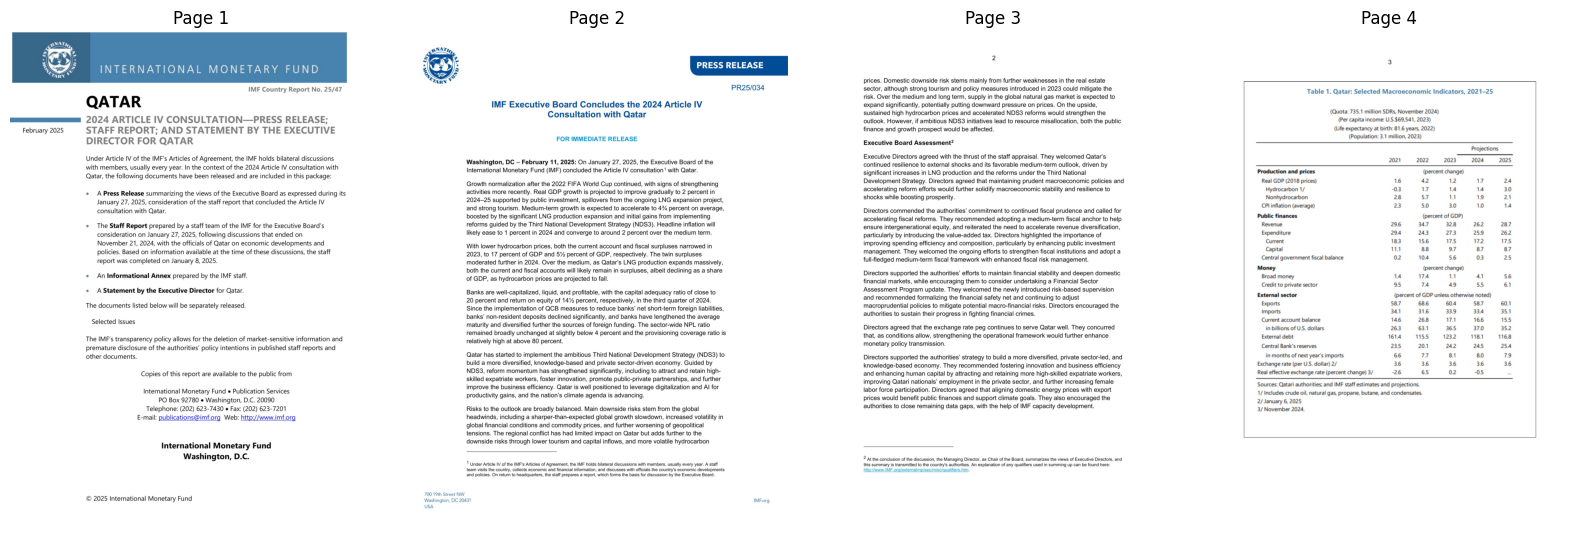

✅ Cell 4 complete: preview shown (if available).


In [ ]:
# ============================
# Cell 4: Preview first few pages
# ============================

if not all_images:
    print(" No images available to preview. Check previous cell output.")
else:
    first_doc_id = sorted(all_images.keys())[0]
    pages = all_images[first_doc_id]

    if len(pages) == 0:
        print(f" PDF {pdf_files_ordered[first_doc_id]} has 0 converted pages.")
    else:
        num_to_show = min(4, len(pages))

        print(f" Previewing {num_to_show} page(s) from doc_id={first_doc_id} ({pdf_files_ordered[first_doc_id]})")

        fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 10))

        # Ensure axes is iterable
        if num_to_show == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(pages[i])
            ax.set_title(f"Page {i + 1}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

print(" Cell 4 complete: preview shown (if available).")

In [ ]:
# ============================
# Cell 5: Safe Google Package Conflict Patch
# ============================

"""
Several Colab environments include a broken namespace package for `google`
that interferes with libraries like `google-auth`, `google-cloud`, etc.

Instead of deleting system files (dangerous), we patch sys.path at runtime
to ensure the correct namespace packages load first.
"""

import sys
import site
import os

def fix_google_conflicts():
    paths = site.getsitepackages() + sys.path
    bad_paths = [p for p in paths if p.endswith("dist-packages/google")]

    if bad_paths:
        print(" Detected a conflicting google/ namespace directory.")
        for p in bad_paths:
            print("   Removing from sys.path:", p)
            try:
                sys.path.remove(p)
            except:
                pass
    else:
        print(" No google namespace conflicts found.")

    # Force-refresh module import state
    if "google" in sys.modules:
        del sys.modules["google"]

    print(" Google namespace patched safely.")


fix_google_conflicts()

print(" Cell 5 complete: Google package conflict handled without removing system files.")

✔ No google namespace conflicts found.
✅ Google namespace patched safely.
✅ Cell 5 complete: Google package conflict handled without removing system files.


In [ ]:
# ============================
# Cell 6: Ensure Correct Protobuf Version
# ============================

import pkg_resources
import subprocess
import sys

REQUIRED_PROTOBUF_VERSION = "3.20.3"

def ensure_protobuf(version=REQUIRED_PROTOBUF_VERSION):
    try:
        installed_version = pkg_resources.get_distribution("protobuf").version
        print(f" Detected protobuf version: {installed_version}")

        if installed_version != version:
            print(f" Protobuf mismatch. Installing version {version} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet",
                                   f"protobuf=={version}", "--force-reinstall"])
        else:
            print(" Protobuf version is correct.")
    except Exception as e:
        print(" Protobuf missing or error occurred:", e)
        print(f" Installing protobuf=={version} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet",
                               f"protobuf=={version}", "--force-reinstall"])

    print(" Protobuf installation check complete.")


ensure_protobuf()


/tmp/ipython-input-2690128979.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


🔍 Detected protobuf version: 3.20.3
✔ Protobuf version is correct.
✅ Protobuf installation check complete.


In [ ]:
# ============================
# Cell 7: Load ColPali & Index Images (Corrected)
# ============================

# Detect device (used later for processing)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(" Device for ColPali:", device)

# ----------------------------
# STEP 1 — Validate image directory
# ----------------------------
if not os.path.exists(data_dir):
    raise RuntimeError(f" data/ directory not found: {data_dir}")

print(" Images for indexing will come from:", data_dir)

# ----------------------------
# STEP 2 — Load ColPali model (NO dtype, NO device_map)
# ----------------------------
try:
    docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")
    print(" Loaded ColPali multimodal retriever successfully.")

except Exception as e:
    print(" ERROR: Failed to load ColPali model.")
    print("Reason:", e)
    raise e

# ----------------------------
# STEP 3 — Prepare temporary image folder for page images
# ----------------------------
image_index_dir = "colpali_images"
os.makedirs(image_index_dir, exist_ok=True)

# Clear old images
for f in os.listdir(image_index_dir):
    os.remove(os.path.join(image_index_dir, f))

print(" Cleaned temporary ColPali image folder.")

# Save PIL pages as PNG for ColPali
png_paths = []
for doc_id, pages in all_images.items():
    for pnum, pil_img in enumerate(pages, start=1):
        png_path = os.path.join(image_index_dir, f"doc{doc_id}_page{pnum}.png")
        pil_img.save(png_path, "PNG")
        png_paths.append(png_path)

print(f" Saved {len(png_paths)} page images for ColPali indexing.")

# ----------------------------
# STEP 4 — Build image index
# ----------------------------
try:
    docs_retrieval_model.index(
        input_path=image_index_dir,
        index_name="image_index",
        store_collection_with_index=False,
        overwrite=True
    )
    print(" ColPali index built over converted PDF page images.")
except Exception as e:
    print(" ERROR while indexing images with ColPali:", e)
    raise e

print(" Cell 7 complete: ColPali image index ready.")

`torch_dtype` is deprecated! Use `dtype` instead!


🔌 Device for ColPali: cuda
📁 Images for indexing will come from: data
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🤖 Loaded ColPali multimodal retriever successfully.
🧹 Cleaned temporary ColPali image folder.
🖼 Saved 78 page images for ColPali indexing.
overwrite is on. Deleting existing index image_index to build a new one.
Indexing file: colpali_images/doc0_page71.png
Added page 1 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page13.png
Added page 1 of document 1 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page8.png
Added page 1 of document 2 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page5.png
Added page 1 of document 3 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page21.png
Added page 1 of document 4 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page45.png
Added page 1 of document 5 to index.
Index exported to .byaldi/image_index
Indexing file: colpali_images/doc0_page17.png
Added page 1 of do

In [ ]:
# ============================
# Cell 8 (FIXED): Reliable text + table + chart ingestion
# ============================

text_table_chunks = []
chart_images = []

# --------------------------------------------------------------------
# Utility: add chunk with priority (narrative > tables > charts > OCR)
# --------------------------------------------------------------------
def add_chunk(doc_id, doc_name, page_num, content, modality, weight):
    text_table_chunks.append({
        "chunk_id": len(text_table_chunks),
        "doc_id": doc_id,
        "doc_name": doc_name,
        "page_num": page_num,
        "modality": modality,
        "content": content.strip(),
        "weight": weight,       # NEW: retrieval weight
    })


# --------------------------------------------------------------------
# CLEAN PARAGRAPH TEXT
# --------------------------------------------------------------------
def clean_paragraph(p):
    p = re.sub(r"\s+", " ", p).strip()
    # remove page headers/footers/section numbers
    if len(p) < 35:
        return ""
    bad = ["\u00a9", "IMF", "Table", "Figure", "Source:", "Country Report"]
    if any(b in p[:18] for b in bad):
        return ""
    return p


# --------------------------------------------------------------------
# SEMANTIC PARAGRAPH CHUNKING (3–5 sentence blocks)
# --------------------------------------------------------------------
def semantic_chunk(paragraph, max_sent=5):
    sents = re.split(r"(?<=[.!?])\s+", paragraph)
    out = []
    for i in range(0, len(sents), max_sent):
        block = " ".join(sents[i:i+max_sent]).strip()
        if len(block) > 50:
            out.append(block)
    return out


# --------------------------------------------------------------------
# TABLE EXTRACTION (reliable pdfplumber, no Camelot noise)
# --------------------------------------------------------------------
def extract_tables_plumber(page, doc_id, doc_name, page_num):
    try:
        tables = page.extract_tables()
        for tbl in tables:
            header = " | ".join(tbl[0])
            add_chunk(doc_id, doc_name, page_num,
                      "TABLE HEADER: " + header,
                      modality="table_header", weight=0.80)

            for row in tbl[1:]:
                row_text = " | ".join(row)
                if len(row_text.strip()) > 10:
                    add_chunk(doc_id, doc_name, page_num,
                              "ROW: " + row_text,
                              modality="table_row", weight=0.75)
    except:
        pass


# --------------------------------------------------------------------
# CHART DETECTION (region-based, avoids false positives)
# --------------------------------------------------------------------
def detect_chart_regions(pil_img):
    img = np.array(pil_img.convert("L"))
    h, w = img.shape

    # check only central horizontal strip (where charts usually exist)
    region = img[h//4: 3*h//4, w//6: 5*w//6]
    edges = cv2.Canny(region, 60, 160)
    score = edges.mean()

    # stricter threshold reduces false chart-detections
    return score > 0.065


# --------------------------------------------------------------------
# MAIN INGESTION LOOP
# --------------------------------------------------------------------
for doc_id, pdf_name in enumerate(pdf_files_ordered):
    pdf_path = os.path.join(data_dir, pdf_name)
    print(f" Processing doc_id={doc_id}, file={pdf_name}")

    with pdfplumber.open(pdf_path) as pdf:
        for p_idx, page in enumerate(pdf.pages):
            page_num = p_idx + 1

            # ---------- TEXT ----------
            raw = page.extract_text() or ""
            raw = raw.replace("\x00", "").strip()

            if len(raw) < 40:     # fallback to OCR
                try:
                    pil_img = page.to_image(resolution=250).original
                    raw = pytesseract.image_to_string(pil_img, lang="eng")
                except:
                    raw = ""

            # paragraph split
            paras = [clean_paragraph(p) for p in raw.split("\n") if p.strip()]
            paras = [p for p in paras if p]

            for p in paras:
                chunks = semantic_chunk(p)
                for ch in chunks:
                    add_chunk(doc_id, pdf_name, page_num,
                              ch, modality="text", weight=1.0)

            # ---------- TABLES ----------
            extract_tables_plumber(page, doc_id, pdf_name, page_num)

    # ---------- CHARTS (region-based) ----------
    for pnum, pil_img in enumerate(all_images[doc_id], start=1):
        if detect_chart_regions(pil_img):
            caption = pytesseract.image_to_string(pil_img, lang="eng").strip()
            caption = re.sub(r"\s+", " ", caption)
            if len(caption) > 40:
                add_chunk(doc_id, pdf_name, pnum,
                          "CHART CAPTION OCR: " + caption[:300],
                          modality="chart_caption", weight=0.60)

                chart_images.append({
                    "doc_id": doc_id,
                    "page_num": pnum,
                    "doc_name": pdf_name,
                    "image": pil_img
                })

    print(f"   Done. Total chunks so far = {len(text_table_chunks)} | Charts = {len(chart_images)}")

print(" INGESTION SUMMARY")
print(f"  - Narrative/table/chart chunks: {len(text_table_chunks)}")
print(f"  - Charts detected: {len(chart_images)}")
print(" Cell 8 (fixed) complete: High-quality multi-modal ingestion ready.")


📘 Processing doc_id=0, file=QATAR_DOC.pdf


   ✔ Done. Total chunks so far = 1855 | Charts = 77

📊 INGESTION SUMMARY
  - Narrative/table/chart chunks: 1855
  - Charts detected: 77
✅ Cell 8 (fixed) complete: High-quality multi-modal ingestion ready.


In [ ]:
# ============================
# Cell 9 (FIXED): Weighted embeddings + unified FAISS index
# ============================

import pickle
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(" Device for embeddings:", device)

# ---------- TEXT EMBEDDER ----------
embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
text_tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
text_model = AutoModel.from_pretrained(embed_model_name).to(device).eval()

def embed_texts(texts, batch_size=32):
    if not texts:
        return np.zeros((0, text_model.config.hidden_size), dtype="float32")
    out_vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = text_tokenizer(batch, padding=True, truncation=True,
                                 max_length=256, return_tensors="pt")
            enc = {k: v.to(device) for k, v in enc.items()}
            out = text_model(**enc)
            token_emb = out.last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)
            token_emb = token_emb * mask
            summed = token_emb.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            pooled = (summed / counts).cpu()
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            out_vecs.append(pooled)
    return torch.cat(out_vecs, dim=0).numpy().astype("float32")


# ---------- IMAGE EMBEDDER ----------
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device).eval()

def embed_images(pil_images, batch_size=8):
    if not pil_images:
        return np.zeros((0, 512), dtype="float32")
    vecs = []
    with torch.no_grad():
        for i in range(0, len(pil_images), batch_size):
            batch = pil_images[i:i+batch_size]
            enc = clip_processor(images=batch, return_tensors="pt", padding=True).to(device)
            out = clip_model.get_image_features(**enc)
            out = torch.nn.functional.normalize(out, p=2, dim=1).cpu().numpy().astype("float32")
            vecs.append(out)
    return np.vstack(vecs)


# ---------- PREPARE DATA ----------
texts_for_embedding = []
text_metadata = []
text_weights = []   # NEW: store weights

for c in text_table_chunks:
    texts_for_embedding.append(c["content"])
    text_metadata.append({
        "type": c["modality"],
        "doc_id": c["doc_id"],
        "doc_name": c["doc_name"],
        "page_num": c["page_num"],
        "content": c["content"],
        "weight": c["weight"],
    })
    text_weights.append(c["weight"])

image_pages = []
image_metadata = []
image_weights = []   # give images LOWER weight than text
for doc_id, pages in all_images.items():
    for pnum, pil_img in enumerate(pages, start=1):
        image_pages.append(pil_img)
        image_metadata.append({
            "type": "page_image",
            "doc_id": doc_id,
            "doc_name": pdf_files_ordered[doc_id],
            "page_num": pnum,
            "content": None,
            "weight": 0.40,
        })
        image_weights.append(0.40)

print(f"Text chunks: {len(texts_for_embedding)} | Image pages: {len(image_pages)}")


# ---------- COMPUTE EMBEDDINGS ----------
text_embs = embed_texts(texts_for_embedding)
image_embs = embed_images(image_pages)

# ---------- UNIFY DIM ----------
dim = max(text_embs.shape[1], image_embs.shape[1], 512)

def pad(arr, dim):
    if arr.shape[1] == dim:
        return arr
    return np.pad(arr, ((0,0),(0, dim - arr.shape[1])), mode="constant")

text_embs = pad(text_embs, dim)
image_embs = pad(image_embs, dim)


# ---------- WEIGHT MULTIPLIER ----------
# Weight scale: 1.0 (narrative), 0.8 (tables), 0.6 (charts), 0.4 (images)
# ---------- WEIGHT MULTIPLIER ----------
text_embs = text_embs * np.array(text_weights)[:, None]
image_embs = image_embs * np.array(image_weights)[:, None]

# Ensure FAISS-compliant arrays (float32 & contiguous)
text_embs = np.ascontiguousarray(text_embs, dtype="float32")
image_embs = np.ascontiguousarray(image_embs, dtype="float32")

# L2 normalize for cosine similarity
faiss.normalize_L2(text_embs)
faiss.normalize_L2(image_embs)

all_embs = np.vstack([text_embs, image_embs]).astype("float32")
print("Final embedding matrix:", all_embs.shape)

index = faiss.IndexFlatIP(dim)
index.add(all_embs)

metadata_store = text_metadata + image_metadata

faiss.write_index(index, "multimodal_index.faiss")
with open("metadata_store.pkl", "wb") as f:
    pickle.dump(metadata_store, f)

print(" Cell 9 fixed: Weighted FAISS index built")

🔌 Device for embeddings: cuda
Text chunks: 1855 | Image pages: 78
Final embedding matrix: (1933, 512)
✅ Cell 9 fixed: Weighted FAISS index built


In [ ]:
# ============================
# Cell 10 (Safer): Load Qwen2-VL with memory-aware fallbacks
# ============================

import torch, gc, sys, traceback
from transformers import logging
logging.set_verbosity_error()

# Cleanup before attempting to load
torch.cuda.empty_cache()
gc.collect()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Target device:", device)

VLM_MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"  # keep this, but we'll try memory-safe options

vl_model = None
vl_processor = None
load_errors = []

# Try progressive load strategies:
load_strategies = [
    {"low_cpu_mem_usage": True, "device_map": "auto", "torch_dtype": torch.float16 if device=="cuda" else torch.float32},
    {"low_cpu_mem_usage": True, "device_map": "auto"},
    {"low_cpu_mem_usage": True},
    {}
]

for strat in load_strategies:
    try:
        print("Attempting to load VLM with strategy:", strat)
        # Use kwargs carefully; transformers will error on unsupported kwargs for custom classes,
        # so build call dynamically and catch TypeError
        kwargs = dict(strat)
        # Some model classes don't accept device_map/torch_dtype; attempt guarded call
        try:
            vl_model = Qwen2VLForConditionalGeneration.from_pretrained(VLM_MODEL_ID, **kwargs)
        except TypeError:
            # fallback: try without device_map/torch_dtype
            simple_kwargs = {k: v for k, v in kwargs.items() if k in ("low_cpu_mem_usage",)}
            vl_model = Qwen2VLForConditionalGeneration.from_pretrained(VLM_MODEL_ID, **simple_kwargs)

        # Move model to device (this may still OOM)
        try:
            vl_model = vl_model.to(device)
        except Exception as e:
            print("Warning: moving to device failed:", e)

        # Load processor
        try:
            vl_processor = Qwen2VLProcessor.from_pretrained(VLM_MODEL_ID, min_pixels=224*224, max_pixels=1024*1024)
        except Exception as e:
            print("Warning: failed to load processor:", e)
            # processor may be optional for text-only fallback

        print(" VLM loaded with strategy:", strat)
        break
    except Exception as e:
        tb = traceback.format_exc()
        load_errors.append((strat, str(e)))
        print("Load attempt failed for strategy:", strat, " — error:", e)
        print("Traceback snippet:", tb.splitlines()[-3:])
        # cleanup and try next strategy
        try:
            del vl_model
        except:
            pass
        torch.cuda.empty_cache()
        gc.collect()
        vl_model = None
vl_processor = None

if vl_model is None:
    print(" All VLM load attempts failed. Falling back to text-only mode.")
    print("Errors from attempts:")
    for strat, err in load_errors:
        print(" -", strat, ":", err)
    # Keep vl_model = None so later code uses fallback path
else:
    print(" VLM is ready. Model device:", next(vl_model.parameters()).device if any(True for _ in vl_model.parameters()) else "unknown")

# ----------------------------
# Helper: robust generation (works if vl_model present; otherwise text-only fallback)
# ----------------------------
def generate_answer_safe(system_instruction, user_question, text_snippets=None, image_list=None, max_new_tokens=256):
    """
    Returns (answer_text, debug_info)
    If vl_model is not available, returns a placeholder that can be handled by your QA flow.
    """
    debug = {"vl_available": vl_model is not None, "device": device}
    if vl_model is None:
        # Simple text-only fallback: concatenate top text snippets and return a safe response string.
        context = "\n\n".join((text_snippets or [])[:6])  # limit context size
        fallback = (
            "VLM unavailable in this runtime. Using text-only fallback.\n\n"
            f"Context (truncated):\n{context[:2000]}\n\nUser question: {user_question}\n\n"
            "Please run this notebook on a larger GPU (Colab Pro/GPU with >16GB) or use the HuggingFace/Inference API for Qwen2-VL."
        )
        return fallback, debug

    # Build content blocks for vl_processor
    content_blocks = [{"type": "text", "text": system_instruction}]
    for t in (text_snippets or [])[:10]:  # limit to first N snippets for memory reasons
        content_blocks.append({"type": "text", "text": t})
    content_blocks.append({"type": "text", "text": "User question: " + user_question})
    chat_template = [{"role":"user", "content": content_blocks}]

    # Apply template safely
    try:
        raw_text = vl_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    except Exception:
        raw_text = system_instruction + "\n\n" + "\n\n".join((text_snippets or [])[:6]) + "\n\nUser question: " + user_question

    # Limit images passed to at most 1 or 2 to avoid memory blowups
    limited_images = (image_list or [])[:1]

    try:
        if limited_images:
            image_inputs, _ = process_vision_info(chat_template)
            inputs = vl_processor(text=[raw_text], images=image_inputs, padding=True, return_tensors="pt")
        else:
            inputs = vl_processor(text=[raw_text], padding=True, return_tensors="pt")
    except Exception:
        # fallback to text-only if processor fails
        inputs = vl_processor(text=[raw_text], padding=True, return_tensors="pt")

    # Move to device
    try:
        inputs = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k,v in inputs.items()}
    except Exception:
        pass

    # Try generation
    try:
        out = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
        # Trim prefix using input length if present
        if "input_ids" in inputs:
            inlen = inputs["input_ids"].shape[1]
            out_trim = out[:, inlen:]
        else:
            out_trim = out
        answer = vl_processor.batch_decode(out_trim, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        return answer, {"vl_available": True}
    except RuntimeError as re:
        # probable OOM: clear cache and return error message rather than crashing
        torch.cuda.empty_cache()
        gc.collect()
        return f"Generation failed due to runtime error: {re}", {"vl_available": True, "error": str(re)}
    except Exception as e:
        return f"Generation failed: {e}", {"vl_available": True, "error": str(e)}

print("Safer VLM loader complete. Use generate_answer_safe(...) to produce answers without crashing.")

Target device: cuda
Attempting to load VLM with strategy: {'low_cpu_mem_usage': True, 'device_map': 'auto', 'torch_dtype': torch.float16}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ VLM loaded with strategy: {'low_cpu_mem_usage': True, 'device_map': 'auto', 'torch_dtype': torch.float16}

✅ VLM is ready. Model device: cuda:0
Safer VLM loader complete. Use generate_answer_safe(...) to produce answers without crashing.


In [ ]:
# ============================
# Cell 11 (FIXED): Weighted multimodal retrieval
# ============================

import math
import pickle
import numpy as np

def ensure_index_loaded(index_path="multimodal_index.faiss", meta_path="metadata_store.pkl"):
    global index, metadata_store, INDEX_DIM
    if "index" not in globals() or index is None:
        index = faiss.read_index(index_path)
    if "metadata_store" not in globals() or metadata_store is None:
        with open(meta_path, "rb") as f:
            metadata_store = pickle.load(f)
    INDEX_DIM = index.d
    print(f"Index vectors={index.ntotal}, Metadata={len(metadata_store)}, dim={INDEX_DIM}")


def pad_or_truncate(arr, target_dim):
    if arr.shape[1] == target_dim:
        return arr
    if arr.shape[1] < target_dim:
        return np.pad(arr, ((0,0),(0,target_dim-arr.shape[1])), mode="constant")
    return arr[:, :target_dim]


def embed_query_text(query):
    ensure_index_loaded()
    q = embed_texts([query])
    q = pad_or_truncate(q, INDEX_DIM)
    faiss.normalize_L2(q)
    return q


def search_faiss(query, top_k=10):
    ensure_index_loaded()
    q_emb = embed_query_text(query)
    D, I = index.search(q_emb, top_k)

    results = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0:
            continue
        meta = metadata_store[idx]
        # ---- weighted score final ----
        final_score = score * meta.get("weight", 1.0)
        results.append({
            "score": float(final_score),
            "raw_score": float(score),
            "meta": meta,
            "index_id": int(idx)
        })
    # sort by weighted score
    results.sort(key=lambda x: x["score"], reverse=True)
    return results


def normalize_scores(results):
    if not results:
        return results
    vals = [r["score"] for r in results]
    mn, mx = min(vals), max(vals)
    for r in results:
        if math.isclose(mx, mn):
            r["norm_score"] = 1.0
        else:
            r["norm_score"] = (r["score"] - mn) / (mx - mn)
    return results


# unified retrieval
def retrieve_multi_modal(query, k_faiss=8, k_colpali=3):
    ensure_index_loaded()
    out = []

    # ----- FAISS weighted -----
    faiss_res = search_faiss(query, top_k=k_faiss)
    normalize_scores(faiss_res)

    for r in faiss_res:
        m = r["meta"]
        out.append({
            "modality": m["type"],
            "doc_id": m["doc_id"],
            "doc_name": m["doc_name"],
            "page_num": m["page_num"],
            "content": m["content"],
            "score": r["score"],
            "norm_score": r["norm_score"],
            "source": "faiss",
        })

    # ----- OPTIONAL: COLPALI -----
    if "docs_retrieval_model" in globals() and docs_retrieval_model is not None:
        try:
            raw = docs_retrieval_model.search(query, k=k_colpali)
            for r in raw:
                out.append({
                    "modality": "page_image",
                    "doc_id": int(r["doc_id"]),
                    "doc_name": pdf_files_ordered[int(r["doc_id"])],
                    "page_num": int(r["page_num"]),
                    "content": None,
                    "score": float(r["score"] * 0.3),
                    "norm_score": float(r["score"]),
                    "source": "colpali"
                })
        except Exception as e:
            print(" ColPali failed:", e)

    # sort + dedup
    out.sort(key=lambda x: x["score"], reverse=True)
    seen = set()
    final = []
    for r in out:
        key = (r["doc_id"], r["page_num"], r["modality"])
        if key not in seen:
            seen.add(key)
            final.append(r)

    return final


def prepare_context_for_model(retrieved, max_text=4, max_img=2):
    text_snips, img_snips, used_meta = [], [], []
    t = im = 0
    for r in retrieved:
        if r["modality"] in ("text", "table_row", "table_header", "chart_caption") and t < max_text:
            text_snips.append(f"[p.{r['page_num']}] {r['content']}")
            used_meta.append(r)
            t += 1
        elif r["modality"] == "page_image" and im < max_img:
            img = all_images[r["doc_id"]][r["page_num"] - 1]
            img_snips.append(img)
            used_meta.append(r)
            im += 1
        if t >= max_text and im >= max_img:
            break
    return text_snips, img_snips, used_meta

print(" Cell 11 fixed")

✅ Cell 11 fixed


In [ ]:
# ============================
# Cell 12: Multi-modal RAG QA (corrected for weighted retrieval)
# ============================
import textwrap
from typing import Tuple, List, Dict, Any

def format_sources(used_metadata: List[Dict[str, Any]]):
    """Create deduplicated citation block."""
    seen = set()
    lines = []
    for m in used_metadata:
        doc = m.get("doc_name") or m.get("doc") or "unknown"
        page = m.get("page_num") or m.get("page") or "?"
        key = (doc, page)
        if key not in seen:
            seen.add(key)
            lines.append(f"- {doc} [p.{page}]")
    return "\n".join(lines)


def answer_with_multimodal_rag(
    query: str,
    top_k_faiss: int = 8,
    top_k_colpali: int = 3,
    max_text_snips: int = 4,
    max_img_snips: int = 2,
    max_new_tokens: int = 256
) -> Tuple[str, List[Dict[str, Any]]]:

    # ===== 1) Retrieve ranked results (weighted FAISS + ColPali) =====
    retrieved = retrieve_multi_modal(query, k_faiss=top_k_faiss, k_colpali=top_k_colpali)

    # ===== 2) Build context snippets =====
    text_snips, img_snips, used_meta = prepare_context_for_model(
        retrieved,
        max_text=max_text_snips,
        max_img=max_img_snips
    )

    # Extract page list for instruction header
    pages_used = sorted({
        m.get("page_num") or m.get("page") for m in used_meta if m.get("page_num") or m.get("page")
    })
    pages_info = ", ".join(map(str, pages_used)) if pages_used else "N/A"

    # ===== 3) System instruction: force citations strictly =====
    system_instruction = textwrap.dedent(f"""
        You are a strict multi-modal retrieval-augmented model.
        Only answer based on the provided context blocks.

        Rules:
        - Every factual statement MUST be directly traceable to a provided snippet.
        - Every claim MUST include a citation of the form [p.X].
        - If the context does not contain enough information, you MUST answer:
          "I am unsure based on the provided documents."
        - Do NOT hallucinate missing numbers, tables, or narrative text.

        Pages retrieved: {pages_info}
    """).strip()

    # ===== 4) Generate the answer (text or VL depending on availability) =====
    answer, gen_debug = generate_answer_safe(
        system_instruction,
        query,
        text_snippets=text_snips,
        image_list=img_snips,
        max_new_tokens=max_new_tokens
    )

    # ===== 5) Append sources used (verified, deduped) =====
    sources_block = "\n\nSources:\n" + (format_sources(used_meta) if used_meta else "- (no sources retrieved)")

    final_answer = answer.strip() + sources_block

    return final_answer, used_meta


print(" Cell 12 fixed: RAG QA is now aligned with weighted retrieval + strict citations.")

✅ Cell 12 fixed: RAG QA is now aligned with weighted retrieval + strict citations.


In [ ]:
# ============================
# Cell 13 (Hardened): Manual QA test + Evaluation Suite (batch)
# ============================

import json
import csv
import time
import traceback
from typing import Dict, Any, List

# ---------- Text normalization ----------
def normalize_text(s: str) -> str:
    if not s:
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9.% ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def containment_score(gold: str, pred: str) -> float:
    gold_n = normalize_text(gold)
    pred_n = normalize_text(pred)
    if not gold_n or not pred_n:
        return 0.0
    return 1.0 if gold_n in pred_n else 0.0


def exact_match_score(gold: str, pred: str) -> float:
    return 1.0 if normalize_text(gold) == normalize_text(pred) else 0.0


# ============================================================
# MANUAL TEST MODE
# ============================================================

def manual_test(query: str, safe: bool = True):
    print("Running manual RAG QA for query:\n", query)
    start = time.time()

    try:
        ans, used_meta = answer_with_multimodal_rag(
            query,
            top_k_faiss=6,
            top_k_colpali=3,
            max_text_snips=4,
            max_img_snips=2,
            max_new_tokens=200
        )
    except Exception as e:
        print(" ERROR in manual_test:")
        traceback.print_exc()
        return None, []

    dur = time.time() - start
    print(f"\n--- ANSWER (duration: {dur:.1f}s) ---\n")
    print(ans if ans else "(no answer generated)")

    print("\n--- CONTEXT USED ---")
    if not used_meta:
        print("(no retrieval metadata)")
    else:
        for m in used_meta:
            try:
                doc = m.get("doc_name")
                page = m.get("page_num")
                mod = m.get("modality")
                score = m.get("score", None)
                print(f" - {doc} | p.{page} | {mod} | score={score}")
            except:
                print(" - (malformed metadata entry)", m)

    return ans, used_meta


# Quick test
test_query = "What are the main drivers of Qatar’s projected medium-term GDP growth according to the Staff Report?"
_manual_ans, _manual_meta = manual_test(test_query)


# ============================================================
# BATCH EVALUATION SUITE
# ============================================================

EVAL_SET = [
    {
        "id": "text_1",
        "modality": "text",
        "question": "According to the report, what are key priorities for enhancing human capital in Qatar?",
        "gold_answer": "human capital"
    },
    {
        "id": "table_1",
        "modality": "table",
        "question": "According to Table 1, what is Qatar’s projected real GDP growth for 2024?",
        "gold_answer": "2.7"
    },
    {
        "id": "chart_1",
        "modality": "chart",
        "question": "Based on the report’s figures, does unemployment trend upward or downward after 2020?",
        "gold_answer": "downward"
    }
]


def run_evaluation(eval_set: List[Dict[str, Any]] = None, out_csv: str = "eval_results.csv"):
    eval_set = eval_set if eval_set else EVAL_SET

    rows = []
    total = len(eval_set)
    cont_total = 0.0
    exact_total = 0.0

    modality_stats = {}

    for item in eval_set:
        qid = item["id"]
        q = item["question"]
        gold = item["gold_answer"]
        mod = item["modality"]

        print("==============================")
        print(f" {qid} | modality={mod} | Q: {q}")

        try:
            pred, used_meta = answer_with_multimodal_rag(
                q,
                top_k_faiss=6,
                top_k_colpali=3,
                max_text_snips=4,
                max_img_snips=2,
                max_new_tokens=200
            )
        except Exception:
            print(" ERROR during answer generation")
            traceback.print_exc()
            pred = "(error)"
            used_meta = []

        cont = containment_score(gold, pred)
        exact = exact_match_score(gold, pred)

        cont_total += cont
        exact_total += exact

        modality_stats.setdefault(mod, {"total": 0, "containment": 0, "exact": 0})
        modality_stats[mod]["total"] += 1
        modality_stats[mod]["containment"] += int(cont)
        modality_stats[mod]["exact"] += int(exact)

        short_pred = pred.replace("\n", " ")[:300]

        print(" Prediction:", short_pred)
        print(f"Containment: {bool(cont)} | Exact: {bool(exact)}")

        # Extract used pages safely
        used_pages = []
        for m in used_meta:
            p = m.get("page_num")
            used_pages.append(p)

        print("Context pages used:", used_pages)

        rows.append({
            "id": qid,
            "modality": mod,
            "question": q,
            "gold": gold,
            "prediction": short_pred,
            "containment": cont,
            "exact": exact,
            "used_pages": json.dumps(used_pages)
        })

    # -------- Summary --------
    acc_cont = cont_total / total
    acc_exact = exact_total / total

    print("\n\n Evaluation Summary")
    print(f"Total = {total}")
    print(f"Containment accuracy = {acc_cont:.2%}")
    print(f"Exact accuracy = {acc_exact:.2%}")

    print("\nPer-modality breakdown:")
    for mod, st in modality_stats.items():
        t = st["total"]
        c = st["containment"]
        e = st["exact"]
        print(f" - {mod}: containment={c}/{t} ({c/t:.2%}), exact={e}/{t} ({e/t:.2%})")

    # Save CSV
    if rows:
        try:
            with open(out_csv, "w", newline="", encoding="utf-8") as f:
                writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
                writer.writeheader()
                writer.writerows(rows)
            print(f"CSV saved: {out_csv}")
        except Exception as e:
            print(" CSV write failed:", e)

    return {
        "total": total,
        "containment_acc": acc_cont,
        "exact_acc": acc_exact,
        "rows": rows
    }


print(" Cell 13 (Hardened) loaded.")

Running manual RAG QA for query:
 What are the main drivers of Qatar’s projected medium-term GDP growth according to the Staff Report?
Index vectors=1933, Metadata=1933, dim=512
Index vectors=1933, Metadata=1933, dim=512
Index vectors=1933, Metadata=1933, dim=512
⚠️ ColPali failed: list index out of range

--- ANSWER (duration: 2.9s) ---

The main drivers of Qatar’s projected medium-term GDP growth according to the Staff Report are non-hydrocarbon growth and the gradual rebound in real GDP growth after the 2022 FIFA World Cup.

Sources:
- QATAR_DOC.pdf [p.46]
- QATAR_DOC.pdf [p.13]
- QATAR_DOC.pdf [p.9]
- QATAR_DOC.pdf [p.39]

--- CONTEXT USED ---
 - QATAR_DOC.pdf | p.46 | text | score=0.7628662586212158
 - QATAR_DOC.pdf | p.13 | chart_caption | score=0.49456167221069336
 - QATAR_DOC.pdf | p.9 | chart_caption | score=0.4672224223613739
 - QATAR_DOC.pdf | p.39 | chart_caption | score=0.4572598934173584
✅ Cell 13 (Hardened) loaded.


In [ ]:
# Inspect + retry cell for the query that returned "I am unsure..."
import matplotlib.pyplot as plt
from IPython.display import display
query = " What are the main drivers of Qatar’s projected medium-term GDP growth according to the Staff Report?"

print("=== Running FAISS-only top results (top_k=12) ===\n")
faiss_results = search_faiss(query, top_k=12)
# convert into readable list (meta inside each result)
for i, r in enumerate(faiss_results, 1):
    meta = r["meta"]
    doc = meta.get("doc_name") or meta.get("doc_id")
    page = meta.get("page_num")
    mtype = meta.get("type") or meta.get("modality") or "text"
    snippet = (meta.get("content") or "")[:800].replace("\n", " ")
    print(f"{i}. score={r['score']:.4f} | doc={doc} | p.{page} | type={mtype}")
    print("   ->", snippet)
    print("-" * 90)

# Also call unified retrieve_multi_modal to include ColPali results
print("\n=== Unified retrieval (FAISS + ColPali) top_k=12 ===\n")
retrieved = retrieve_multi_modal(query, k_faiss=12, k_colpali=6)
for i, r in enumerate(retrieved[:12], 1):
    print(f"{i}. source={r.get('source')} | norm_score={r.get('norm_score'):.3f} | modality={r.get('modality')} | doc={r.get('doc_name')} | p.{r.get('page_num')}")
    if r.get("content"):
        print("   snippet:", (r.get("content") or "")[:400].replace("\n"," "))
    print("-" * 80)

# Display any page images among the top retrieved (visual check)
print("\n=== Displaying up to 4 retrieved page images (if any) ===")
img_count = 0
for r in retrieved:
    if r["modality"] == "page_image":
        try:
            img = all_images[int(r["doc_id"])][int(r["page_num"]) - 1]
            plt.figure(figsize=(6,9))
            plt.imshow(img)
            plt.title(f"{r.get('doc_name')} - p.{r.get('page_num')} (source={r.get('source')})")
            plt.axis("off")
            plt.show()
            img_count += 1
            if img_count >= 4:
                break
        except Exception as e:
            print("Could not display image:", e)

if img_count == 0:
    print("(no page images returned in the top results)")

# ---- Attempt a stronger RAG call with more context ----
print("\n=== Re-running RAG QA with expanded retrieval caps ===\n")
ans_more, meta_more = answer_with_multimodal_rag(
    query,
    top_k_faiss=20,
    top_k_colpali=6,
    max_text_snips=8,
    max_img_snips=3,
    max_new_tokens=300
)
print("\n--- ANSWER (expanded attempt) ---\n")
print(ans_more)
print("\n--- CONTEXT USED (expanded attempt) ---")
if not meta_more:
    print("(no metadata returned)")
else:
    for m in meta_more:
        print(f" - {m.get('doc_name')} | p.{m.get('page_num')} | {m.get('modality')} | source={m.get('source', 'faiss/colpali')}")

=== Running FAISS-only top results (top_k=12) ===

Index vectors: 2894 | Metadata: 2894 | Index dim: 512
Index vectors: 2894 | Metadata: 2894 | Index dim: 512
1. score=0.7908 | doc=QATAR_DOC.pdf | p.13 | type=chart_caption
   -> CHART CAPTION OCR: QATAR  MN OUTLOOK AND RISKS  8. Growth is expected to strengthen gradually in the near term and pick up more forcefully over the medium term. Real GDP growth is projected to improve to 2 percent in 2024— 25, in line with staff's nowcasting estimates     (Text Figure 7 and Annex III), as non- Text Figure 7. Nowcasting of Quarterly Non- hydrocarbon growth gradually increases, hydrocarbon Output Growth supported by public investment, spillovers (PRrSent, year On year)  from the ongoing LNG expansio
------------------------------------------------------------------------------------------
2. score=0.7867 | doc=QATAR_DOC.pdf | p.39 | type=chart_caption
   -> CHART CAPTION OCR: QATAR  Table 1. Qatar: Selected Macroeconomic Indicators, 2020-29     P

Overwriting streamlit_app.py


In [5]:
%%writefile rag_backend.py
import os
import math
import pickle
from typing import List, Dict, Any

import numpy as np
import torch
import faiss
from PIL import Image
from pdf2image import convert_from_path

from transformers import (
    AutoTokenizer,
    AutoModel,
    Qwen2VLForConditionalGeneration,
    Qwen2VLProcessor,
)
from qwen_vl_utils import process_vision_info
from byaldi import RAGMultiModalModel


# ============================
# Global config
# ============================
DATA_DIR = "data"
FAISS_INDEX_PATH = "multimodal_index.faiss"
METADATA_PATH = "metadata_store.pkl"
VLM_MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"
TEXT_EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
COLPALI_MODEL_ID = "vidore/colpali-v1.2"

device = "cuda" if torch.cuda.is_available() else "cpu"


# ============================
# Load PDFs as page images
# ============================
def load_pdfs_and_images(data_dir: str = DATA_DIR):
    pdf_files = sorted(
        [f for f in os.listdir(data_dir) if f.lower().endswith(".pdf")]
    )
    all_images_local: Dict[int, List[Image.Image]] = {}
    for doc_id, pdf_name in enumerate(pdf_files):
        pdf_path = os.path.join(data_dir, pdf_name)
        pages = convert_from_path(pdf_path, dpi=200, fmt="jpeg")
        all_images_local[doc_id] = pages
    return pdf_files, all_images_local


pdf_files_ordered, all_images = load_pdfs_and_images()


# ============================
# Load FAISS index + metadata
# ============================
def load_faiss_and_meta(
    index_path: str = FAISS_INDEX_PATH, meta_path: str = METADATA_PATH
):
    if not os.path.exists(index_path):
        raise FileNotFoundError(f"FAISS index not found at {index_path}")
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"Metadata not found at {meta_path}")

    idx = faiss.read_index(index_path)
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    if idx.ntotal != len(meta):
        print(
            f" index.ntotal ({idx.ntotal}) != len(metadata) ({len(meta)}) – "
            "retrieval still works but alignment might be off."
        )
    return idx, meta, idx.d


index, metadata_store, INDEX_DIM = load_faiss_and_meta()


# ============================
# Text encoder (for query embedding)
# ============================
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_EMB_MODEL)
text_model = AutoModel.from_pretrained(TEXT_EMB_MODEL).to(device).eval()


def embed_texts(texts: List[str], batch_size: int = 32) -> np.ndarray:
    if not texts:
        return np.zeros((0, text_model.config.hidden_size), dtype="float32")
    embs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]
            enc = text_tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt",
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = text_model(**enc)
            token_emb = out.last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)
            token_emb = token_emb * mask
            summed = token_emb.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            pooled = (summed / counts).cpu()
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            embs.append(pooled)
    return torch.cat(embs, dim=0).numpy().astype("float32")


def pad_or_truncate(arr: np.ndarray, target_dim: int) -> np.ndarray:
    if arr is None or arr.size == 0:
        return np.zeros((0, target_dim), dtype="float32")
    b, d = arr.shape
    if d == target_dim:
        return arr.astype("float32")
    if d < target_dim:
        pad_width = target_dim - d
        return np.pad(arr, ((0, 0), (0, pad_width)), mode="constant").astype(
            "float32"
        )
    return arr[:, :target_dim].astype("float32")


def embed_query_text(query: str) -> np.ndarray:
    q_emb = embed_texts([query], batch_size=1)
    q_emb = pad_or_truncate(q_emb, INDEX_DIM)
    faiss.normalize_L2(q_emb)
    return q_emb


# ============================
# ColPali image retriever
# ============================
def build_colpali_index(image_root="colpali_images"):
    os.makedirs(image_root, exist_ok=True)
    # Save page images as PNG
    png_paths = []
    for doc_id, pages in all_images.items():
        for pnum, pil_img in enumerate(pages, start=1):
            png_path = os.path.join(image_root, f"doc{doc_id}_page{pnum}.png")
            if not os.path.exists(png_path):
                pil_img.save(png_path, "PNG")
            png_paths.append(png_path)
    model = RAGMultiModalModel.from_pretrained(COLPALI_MODEL_ID)
    model.index(
        input_path=image_root,
        index_name="image_index",
        store_collection_with_index=False,
        overwrite=True,
    )
    return model


try:
    docs_retrieval_model = build_colpali_index()
except Exception as e:
    print(" ColPali not available:", e)
    docs_retrieval_model = None


# ============================
# FAISS search
# ============================
def search_faiss(query: str, top_k: int = 10) -> List[Dict[str, Any]]:
    q_emb = embed_query_text(query)
    D, I = index.search(q_emb, top_k)
    results = []
    for score, idx_val in zip(D[0], I[0]):
        if int(idx_val) < 0:
            continue
        meta = metadata_store[int(idx_val)]
        results.append(
            {
                "score": float(score),
                "meta": meta,
                "index_id": int(idx_val),
            }
        )
    return results


def normalize_scores(results: List[Dict[str, Any]], key: str = "score"):
    if not results:
        return results
    vals = [r[key] for r in results]
    mn, mx = min(vals), max(vals)
    if math.isclose(mn, mx):
        for r in results:
            r["norm_score"] = 1.0
        return results
    for r in results:
        r["norm_score"] = (r[key] - mn) / (mx - mn)
    return results


# ============================
# Unified retrieval (FAISS + ColPali)
# ============================
def retrieve_multi_modal(
    query: str, k_faiss: int = 8, k_colpali: int = 3
) -> List[Dict[str, Any]]:
    results = []

    # ---- FAISS (text) ----
    faiss_res = search_faiss(query, top_k=k_faiss)
    normalize_scores(faiss_res)
    for r in faiss_res:
        m = r["meta"]
        results.append(
            {
                "modality": m.get("type"),
                "doc_id": m.get("doc_id"),
                "doc_name": m.get("doc_name"),
                "page_num": m.get("page_num"),
                "content": m.get("content"),
                "score": r["score"],
                "norm_score": r.get("norm_score", 0.0),
                "source": "faiss",
            }
        )

    # ---- ColPali (page images) ----
    if docs_retrieval_model is not None and k_colpali > 0:
        try:
            raw = docs_retrieval_model.search(query, k=k_colpali)
            cols = []
            for rr in raw:
                cols.append(
                    {
                        "score": float(rr["score"]),
                        "doc_id": int(rr["doc_id"]),
                        "page_num": int(rr["page_num"]),
                    }
                )
            normalize_scores(cols)
            for c in cols:
                doc_id = c["doc_id"]
                doc_name = (
                    pdf_files_ordered[doc_id]
                    if (0 <= doc_id < len(pdf_files_ordered))
                    else None
                )
                results.append(
                    {
                        "modality": "page_image",
                        "doc_id": c["doc_id"],
                        "doc_name": doc_name,
                        "page_num": c["page_num"],
                        "content": None,
                        "score": c["score"],
                        "norm_score": c.get("norm_score", 0.0),
                        "source": "colpali",
                    }
                )
        except Exception as e:
            print(" ColPali search failed:", e)

    # sort + dedup
    results.sort(key=lambda x: x.get("norm_score", 0.0), reverse=True)

    seen = set()
    unique = []
    for r in results:
        key = (
            r.get("doc_id"),
            r.get("page_num"),
            r.get("modality"),
            (r.get("content") or "")[:120],
        )
        if key in seen:
            continue
        seen.add(key)
        unique.append(r)

    return unique


# ============================
# Context preparation
# ============================
def prepare_context_for_model(
    retrieved: List[Dict[str, Any]], max_text: int = 4, max_img: int = 2
):
    text_snips: List[str] = []
    img_snips: List[Image.Image] = []
    used_meta: List[Dict[str, Any]] = []

    t = im = 0
    for r in retrieved:
        mod = r.get("modality")
        if mod in ("text", "table_row", "table_header", "chart_caption") and t < max_text:
            text_snips.append(f"[p.{r['page_num']}] {r['content']}")
            used_meta.append(
                {
                    "doc_name": r["doc_name"],
                    "page_num": r["page_num"],
                    "modality": mod,
                    "score": r.get("score"),
                    "source": r.get("source", "faiss/colpali"),
                }
            )
            t += 1
        elif mod == "page_image" and im < max_img:
            try:
                img_obj = all_images[r["doc_id"]][r["page_num"] - 1]
                img_snips.append(img_obj)
                used_meta.append(
                    {
                        "doc_name": r["doc_name"],
                        "page_num": r["page_num"],
                        "modality": "page_image",
                        "score": r.get("score"),
                        "source": r.get("source", "colpali"),
                    }
                )
                im += 1
            except Exception:
                continue

        if t >= max_text and im >= max_img:
            break

    return text_snips, img_snips, used_meta


# ============================
# VLM loader + safe generation
# ============================
try:
    vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
        VLM_MODEL_ID,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        device_map="auto",
    )
    vl_processor = Qwen2VLProcessor.from_pretrained(
        VLM_MODEL_ID, min_pixels=224 * 224, max_pixels=1024 * 1024
    )
    vl_available = True
except Exception as e:
    print(" VLM load failed, falling back to text-only:", e)
    vl_model = None
    vl_processor = None
    vl_available = False


def generate_answer_safe(
    system_instruction: str,
    user_question: str,
    text_snippets: List[str] = None,
    image_list: List[Image.Image] = None,
    max_new_tokens: int = 256,
):
    text_snippets = text_snippets or []
    image_list = image_list or []

    if not vl_available:
        # Simple text-only fallback: return context + question for debugging
        context = "\n".join(text_snippets[:8])
        fallback = (
            "VLM unavailable in this runtime. Here is the retrieved context and question:\n\n"
            f"{context}\n\nQuestion: {user_question}"
        )
        return fallback, {"vl_available": False}

    # Build chat input
    content_blocks = [{"type": "text", "text": system_instruction}]
    for t in text_snippets[:10]:
        content_blocks.append({"type": "text", "text": t})
    content_blocks.append({"type": "text", "text": "User question: " + user_question})

    chat = [{"role": "user", "content": content_blocks}]

    try:
        raw_text = vl_processor.apply_chat_template(
            chat, tokenize=False, add_generation_prompt=True
        )
    except Exception:
        raw_text = (
            system_instruction
            + "\n\n"
            + "\n".join(text_snippets[:8])
            + "\n\nUser question: "
            + user_question
        )

    limited_images = image_list[:1]

    try:
        if limited_images:
            image_inputs, _ = process_vision_info(chat)
            inputs = vl_processor(
                text=[raw_text],
                images=image_inputs,
                padding=True,
                return_tensors="pt",
            )
        else:
            inputs = vl_processor(
                text=[raw_text], padding=True, return_tensors="pt"
            )
    except Exception:
        inputs = vl_processor(
            text=[raw_text], padding=True, return_tensors="pt"
        )

    inputs = {
        k: (v.to(device) if isinstance(v, torch.Tensor) else v)
        for k, v in inputs.items()
    }

    with torch.no_grad():
        out = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)

    if "input_ids" in inputs:
        inlen = inputs["input_ids"].shape[1]
        out_trim = out[:, inlen:]
    else:
        out_trim = out

    answer = vl_processor.batch_decode(
        out_trim, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    return answer, {"vl_available": True}


# ============================
# High-level RAG QA
# ============================
def format_sources(used_metadata: List[Dict[str, Any]]) -> str:
    seen = set()
    lines = []
    for m in used_metadata:
        doc = m.get("doc_name") or "unknown"
        page = m.get("page_num") or "?"
        key = (doc, page)
        if key in seen:
            continue
        seen.add(key)
        lines.append(f"- {doc} [p.{page}]")
    return "\n".join(lines)


def answer_with_multimodal_rag(
    query: str,
    top_k_faiss: int = 8,
    top_k_colpali: int = 3,
    max_text_snips: int = 6,
    max_img_snips: int = 2,
    max_new_tokens: int = 256,
):
    # 1) Retrieve
    retrieved = retrieve_multi_modal(
        query, k_faiss=top_k_faiss, k_colpali=top_k_colpali
    )

    # 2) Prepare context
    text_snips, img_snips, used_meta = prepare_context_for_model(
        retrieved, max_text=max_text_snips, max_img=max_img_snips
    )

    pages_used = sorted(
        {
            m.get("page_num")
            for m in used_meta
            if m.get("page_num") is not None
        }
    )
    pages_info = ", ".join(map(str, pages_used)) if pages_used else "N/A"

    system_instruction = f"""
You are a careful multi-modal assistant. Use ONLY the provided context to answer.
Each snippet begins with a page tag like [p.5].

Rules:
- Every factual statement MUST be backed by a snippet and include the same [p.X] citation.
- If the context is insufficient, say: "I am unsure based on the provided documents."

Retrieved candidate pages: {pages_info}
""".strip()

    answer, _ = generate_answer_safe(
        system_instruction,
        query,
        text_snippets=text_snips,
        image_list=img_snips,
        max_new_tokens=max_new_tokens,
    )

    final = answer.strip() + "\n\nSources:\n" + (
        format_sources(used_meta) if used_meta else "- (no sources retrieved)"
    )

    return final, used_meta

Overwriting rag_backend.py


In [6]:
%%writefile streamlit_app.py
import streamlit as st
from rag_backend import (
    retrieve_multi_modal,
    prepare_context_for_model,
    answer_with_multimodal_rag,
)

st.set_page_config(page_title="Multi-Modal RAG QA", layout="wide")
st.title(" Multi-Modal RAG for Qatar Staff Report")
st.caption("Ask questions grounded in the IMF Article IV Qatar document.")


query = st.text_area("Enter your question", height=120)

col1, col2 = st.columns([1, 2], vertical_alignment="top")

with col1:
    st.header(" Retrieval Settings")
    k_faiss = st.slider("FAISS neighbors", 4, 40, 12)
    k_colpali = st.slider("ColPali neighbors", 0, 10, 3)
    max_text = st.slider("Max text snippets", 1, 12, 6)
    max_imgs = st.slider("Max image snippets", 0, 4, 1)
    max_tokens = st.number_input(
        "Max generation tokens", 50, 2048, 256, step=64
    )

    run = st.button("Run RAG")

with col2:
    answer_box = st.empty()
    ctx_box = st.empty()
    img_box = st.empty()


if run:
    if not query.strip():
        st.warning("Please enter a question.")
    else:
        with st.spinner(" Retrieving context..."):
            retrieved = retrieve_multi_modal(
                query, k_faiss=k_faiss, k_colpali=k_colpali
            )
            text_snips, img_snips, used_meta = prepare_context_for_model(
                retrieved, max_text=max_text, max_img=max_imgs
            )

        ctx_box.subheader(" Retrieved Text Context")
        if text_snips:
            for t in text_snips:
                ctx_box.markdown(f"- {t}")
        else:
            ctx_box.info("No text snippets used.")

        img_box.subheader(" Retrieved Page Images")
        if img_snips:
            for im in img_snips:
                img_box.image(im, use_column_width=True)
        else:
            img_box.info("No images used.")

        with st.spinner(" Generating answer..."):
            answer, meta_used = answer_with_multimodal_rag(
                query,
                top_k_faiss=k_faiss,
                top_k_colpali=k_colpali,
                max_text_snips=max_text,
                max_img_snips=max_imgs,
                max_new_tokens=max_tokens,
            )

        answer_box.subheader(" Answer")
        answer_box.write(answer)

Overwriting streamlit_app.py


In [ ]:
!pip install streamlit pyngrok --upgrade

  Using cached pyngrok-7.5.0-py3-none-any.whl.metadata (8.1 kB)
Using cached pyngrok-7.5.0-py3-none-any.whl (24 kB)
  Attempting uninstall: pyngrok
    Found existing installation: pyngrok 5.2.1
    Uninstalling pyngrok-5.2.1:
      Successfully uninstalled pyngrok-5.2.1


In [7]:
from pyngrok import ngrok
ngrok.set_auth_token("35t8mtDVaC11cKDLtWUW73940Wm_4iLdYPQHcSKRLjKaS7VVh")

In [8]:
import os, time
os.system("killall streamlit || true")
os.system("nohup streamlit run streamlit_app.py --server.port 8501 --server.headless true >/dev/null 2>&1 &")
time.sleep(3)

In [9]:
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://salpingian-chauncey-remittent.ngrok-free.dev" -> "http://localhost:8501">